# Repos and libraries

In [1]:
!git clone https://github.com/ncclabsustech/EEGdenoiseNet

Cloning into 'EEGdenoiseNet'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 218 (delta 1), reused 8 (delta 1), pack-reused 208
Receiving objects: 100% (218/218), 172.33 MiB | 37.13 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
!pip install mne -q
!pip install wandb -q

In [3]:
import random
import os
from tqdm.auto import tqdm as tqdm_auto

import numpy as np
from matplotlib import pyplot as plt

import mne

import torch

import wandb
!wandb login

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


# Data analysis

In [4]:
PROJECT_DIR = '/kaggle/working/'
EEGdenoiseNet_DIR = PROJECT_DIR + 'EEGdenoiseNet/data/'

In [5]:
clean_all = np.load(EEGdenoiseNet_DIR + 'EEG_all_epochs.npy')
noisy_eog = np.load(EEGdenoiseNet_DIR + 'EOG_all_epochs.npy')
noisy_emg = np.load(EEGdenoiseNet_DIR + 'EMG_all_epochs.npy')
print(clean_all.shape, noisy_eog.shape, noisy_emg.shape)

(4514, 512) (3400, 512) (5598, 512)


In [6]:
all_data = [clean_all, noisy_eog, noisy_emg]

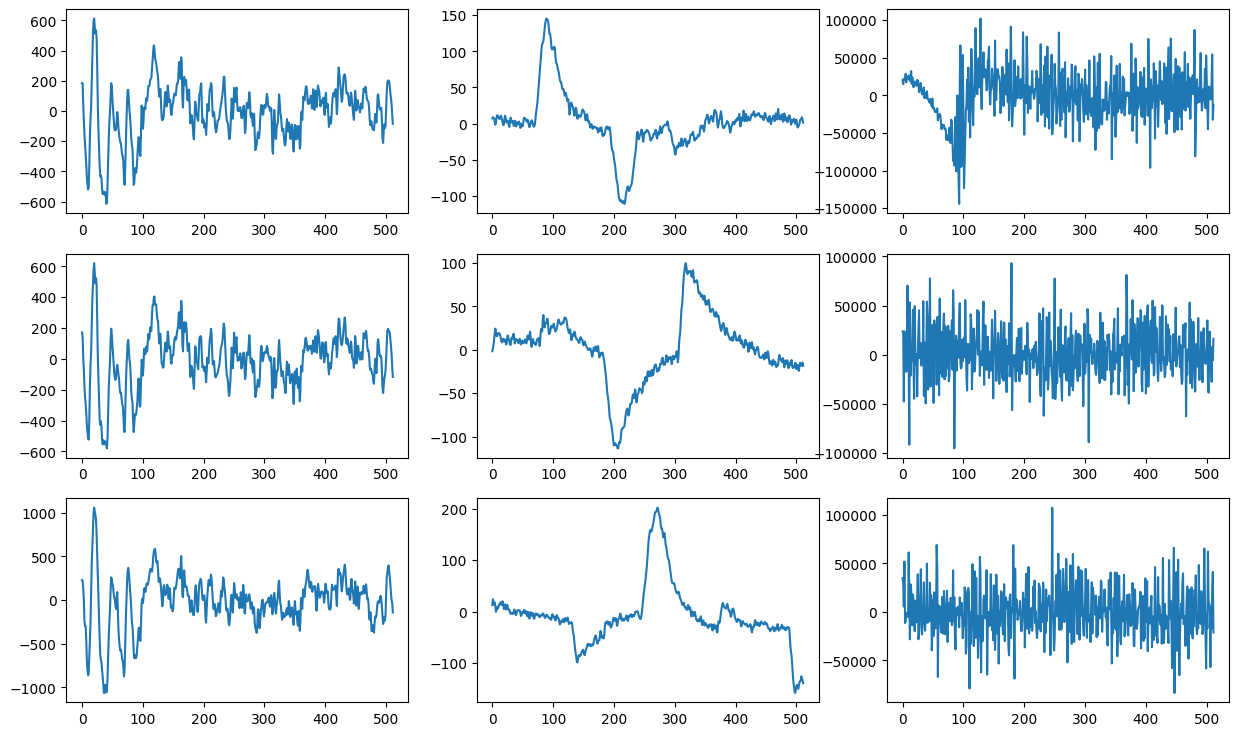

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
for j in range(3):
    for i, data in enumerate(all_data):
        ax[j][i].plot(data[j])

In [8]:
for data in all_data:
    print("Mean", data.mean(), "std", data.std())

Mean -0.013652591849162028 std 228.55191045728395
Mean 0.07290161582875516 std 154.4631755259437
Mean 56.57020022324488 std 33264.08125545235


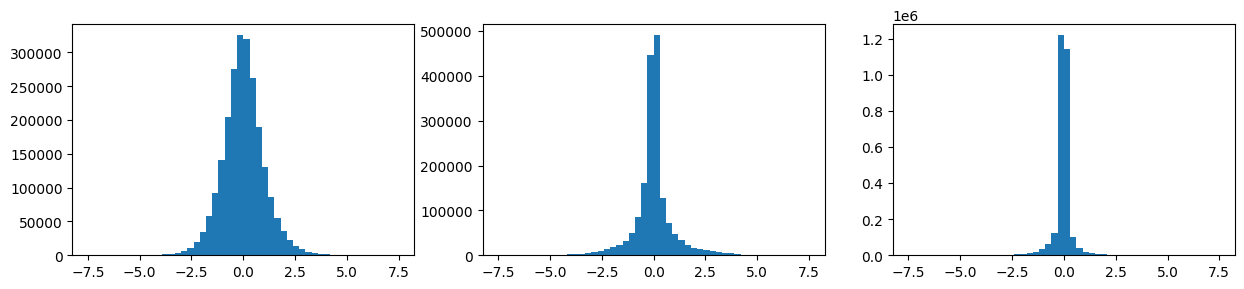

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, data in enumerate(all_data):
    ax[i].hist((data.reshape(-1)-data.mean())/data.std(), bins=50, range=(-7.5, 7.5))

# Dataset

## Generation

In [10]:
def from_db(x):
    return np.power(10, x/10)

def generate_contaminated_data(clean_all, noisy_all, snr_db_list=[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2]):
    clean_data = None
    contaminated_data = None
    for snr_db in tqdm_auto(snr_db_list):
        snr = from_db(snr_db)
        clean_norms = np.linalg.norm(clean_all, axis=1)
        noisy_norms = np.linalg.norm(noisy_all, axis=1)
        lambdas = clean_norms/noisy_norms/snr
        clean_data = np.concatenate([clean_data, clean_all]) if clean_data is not None else clean_all
        contaminated = clean_all + noisy_all*lambdas.reshape(-1, 1)
        contaminated_data = np.concatenate([contaminated_data, contaminated]) if contaminated_data is not None else contaminated
    return clean_data, contaminated_data

In [11]:
# data_length = min(len(clean_all), len(noisy_eog))

# clean_all_truncated = clean_all[:data_length]
# noisy_eog_truncated = noisy_eog[:data_length]

# clean_eog, contaminated_eog = generate_contaminated_data(clean_all_truncated, noisy_eog_truncated)
# print(clean_eog.shape, contaminated_eog.shape)

data_length = min(len(clean_all), len(noisy_emg))

clean_all_truncated = clean_all[:data_length]
noisy_emg_truncated = noisy_emg[:data_length]

clean_emg, contaminated_emg = generate_contaminated_data(clean_all_truncated, noisy_emg_truncated)
print(clean_emg.shape, contaminated_emg.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(45140, 512) (45140, 512)


## Dataloader

In [12]:
data_config = {
    'batch_size': 128,
    'num_workers': 0,
}

In [13]:
from torch.utils.data import Dataset

# class InMemoryDataset(torch.utils.data.Dataset):
#     def __init__(self, clean, noisy, lambda_=1, normalization=True):
#         self.clean = clean
#         self.noisy = noisy
#         self.lambda_ = lambda_
#         self.normalization = normalization

#     def __len__(self):
#         return min(len(self.clean), len(self.noisy))

#     def __getitem__(self, index: int):
#         def normalize(x):
#             return (x - x.mean())/x.std()
        
#         if self.normalization:
#             clean = normalize(self.clean[index])
#             noisy = normalize(self.noisy[index])
#             combined = normalize(self.lambda_*noisy + clean)
        
#         else:
#             clean = self.clean[index]
#             noisy = self.noisy[index]
#             combined = self.lambda_*noisy + clean
        
#         return torch.tensor(clean).unsqueeze(0).float(), torch.tensor(combined).unsqueeze(0).float()
    
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self, clean, contaminated, normalization=True):
        self.clean = clean
        self.contaminated = contaminated
        self.normalization = normalization

    def __len__(self):
        return len(self.contaminated)

    def __getitem__(self, index: int):
        def normalize(x):
            return (x - x.mean())/x.std()

        if self.normalization:
            clean = normalize(self.clean[index])
            contaminated = normalize(self.contaminated[index])
        else:
            clean = self.clean[index]
            contaminated = self.contaminated[index]

        return torch.tensor(clean).unsqueeze(0).float(), torch.tensor(contaminated).unsqueeze(0).float()

In [14]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# clean_train, clean_val_test, noisy_train, noisy_val_test = train_test_split(clean_eog, contaminated_eog, test_size=0.2, random_state=SEED, shuffle=True)
clean_train, clean_val_test, noisy_train, noisy_val_test = train_test_split(clean_emg, contaminated_emg, test_size=0.2, random_state=SEED, shuffle=True)
clean_val, clean_test, noisy_val, noisy_test = train_test_split(clean_val_test, noisy_val_test, test_size=0.5, random_state=SEED, shuffle=True)

train_dataset = InMemoryDataset(clean_train, noisy_train)
val_dataset = InMemoryDataset(clean_val, clean_val)
test_dataset = InMemoryDataset(clean_test, clean_test)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])

print("Train dataset:", len(train_dataset))
print("Val dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

print("Train dataloader:", len(train_dataloader))
print("Val dataloader:", len(val_dataloader))
print("Test dataloader:", len(test_dataloader))

print("Train shape:", train_dataset[0][0].shape)
print("Val shape:", val_dataset[0][0].shape)
print("Test shape:", test_dataset[0][0].shape)

print("Train type:", train_dataset[0][0].type())
print("Val type:", val_dataset[0][0].type())
print("Test type:", test_dataset[0][0].type())

Train dataset: 36112
Val dataset: 4514
Test dataset: 4514
Train dataloader: 283
Val dataloader: 36
Test dataloader: 36
Train shape: torch.Size([1, 512])
Val shape: torch.Size([1, 512])
Test shape: torch.Size([1, 512])
Train type: torch.FloatTensor
Val type: torch.FloatTensor
Test type: torch.FloatTensor


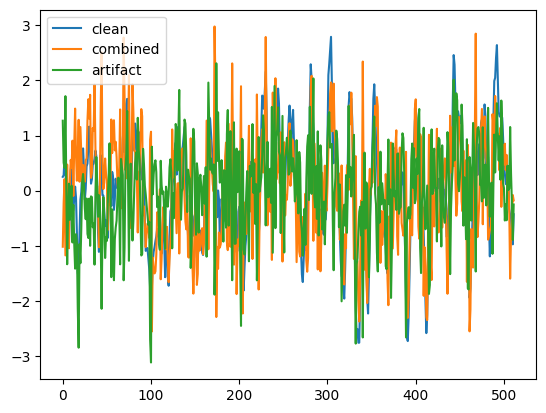

In [15]:
clean, combined = train_dataset[0]
plt.plot(clean.squeeze(), label="clean")
plt.plot(combined.squeeze(), label="combined")
plt.plot((clean - combined).squeeze(), label="artifact")
plt.legend()
plt.show()

# Model

# 1D-ResCNN

In [16]:
import torch
import torch.nn as nn

class CBR(nn.Module):
    def __init__(self, in_channels, out_channels=32, kernel_size=5):
        super().__init__()
        padding = int((kernel_size - 1)/2)

        self.cbr = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.cbr(x)
    
class Resblock(nn.Module):
    def __init__(self, in_channels=32, out_channels=32, kernel_size=5):
        super().__init__()
        
        self.cbr1 = CBR(in_channels, in_channels, kernel_size)
        self.cbr2 = CBR(in_channels, int(in_channels/2), kernel_size)
        self.cbr3 = CBR(int(in_channels/2), out_channels, kernel_size)
        
    def forward(self, x):
        return self.cbr3(self.cbr2(self.cbr1(x))) + x
    
class Resblock_2(nn.Module):
    def __init__(self, in_channels=32, out_channels=32, kernel_size=5):
        super().__init__()
        self.resblock1 = Resblock(in_channels, out_channels, kernel_size)
        self.resblock2 = Resblock(out_channels, out_channels, kernel_size)
                
    def forward(self, x):
        return self.resblock2(self.resblock1(x))
    
class ResCNN_1D(nn.Module):
    def __init__(self, length=512, in_channels=1, out_channels=1, hidden_size=32):
        super().__init__()
        
        self.out_channels = out_channels
        self.cbr_intro = CBR(in_channels, hidden_size, kernel_size=5)
        self.resblock3 = Resblock_2(hidden_size, hidden_size, kernel_size=3)
        self.resblock5 = Resblock_2(hidden_size, hidden_size, kernel_size=5)
        self.resblock7 = Resblock_2(hidden_size, hidden_size, kernel_size=7)
        self.cbr_outro = CBR(hidden_size*3, out_channels, kernel_size=1)
        self.fc = nn.Linear(out_channels*length, out_channels*length)
        
    def forward(self, x):
        x_cbr_intro = self.cbr_intro(x)
        x_resblocks = torch.cat([
            self.resblock3(x_cbr_intro), 
            self.resblock5(x_cbr_intro), 
            self.resblock7(x_cbr_intro)
        ], axis=1)
        x_cbr_outro = self.cbr_outro(x_resblocks)
        x_cbr_outro_shape = x_cbr_outro.shape
        return self.fc(x_cbr_outro.reshape(x_cbr_outro_shape[0], -1)).reshape(x_cbr_outro_shape[0], self.out_channels, -1)

# IC-U-Net

In [17]:
# https://github.com/milesial/Pytorch-UNet
""" Full assembly of the parts to form the complete network """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels,kernel_size=7):
        super().__init__()
        padding = int((kernel_size - 1) / 2)

        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.PReLU(),
#             nn.Sigmoid(),
            #nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.PReLU(),
#             nn.Sigmoid()
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        x1 = self.conv(x)
        return self.maxpool(x1), x1


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size, bilinear=True, concat=True):
        super().__init__()
        self.concat = concat
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            # self.up = F.interpolate()
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        else:
            self.up = nn.ConvTranspose1d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        if concat:
            self.conv = DoubleConv(in_channels*2, out_channels, kernel_size)
        else:
            self.conv = DoubleConv(in_channels, out_channels, kernel_size)

    def forward(self, x, skip=None):
        if self.concat:
            x1 = torch.cat([skip, x], dim=1)
        else:
            x1 = x
        x2 = self.up(x1)
        return self.conv(x2)


class UNet1(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet1, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.down1 = Down(n_channels, 64, kernel_size=7) #64*256
        self.down2 = Down(64, 128, kernel_size=7) #128*128
        self.down3 = Down(128, 256,kernel_size=5) #256*64
        self.neck = DoubleConv(256, 512, kernel_size=3) #512*64
        self.up1 = Up(512, 256, kernel_size=3, concat=False) #256*128
        self.up2 = Up(256, 128, kernel_size=3) #128*256
        self.up3 = Up(128, 64, kernel_size=3) #64*512
        self.outc = DoubleConv(128, n_classes, kernel_size=1) #n_classes*512

    def forward(self, x):
        x, x1_skip = self.down1(x) 
        x, x2_skip = self.down2(x) 
        x, x3_skip = self.down3(x) 
        x = self.neck(x)
        x = self.up1(x)
        x = self.up2(x, x3_skip)
        x = self.up3(x, x2_skip)
        logits = self.outc(torch.cat([x1_skip, x], axis=1))
        return logits

# EEGDnet

In [18]:
import torch
from torch import nn

class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        if dim % num_heads:
            raise ValueError('dim % num_heads != 0')
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        '''
        Args: 
            x: Tensor of shape (batch_size, seq_len, input_dim)
            
        Returns:
            Tensor of shape (batch_size, seq_len, input_dim)
        '''
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # qkv: 3 × B × num_heads × N × head_dim
        q, k, v = qkv.unbind(0)
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v  # attn: B × num_heads × N × N    v: B × num_heads × N × head_dim
        # B × num_heads × N × head_dim
        x = x.transpose(1, 2).reshape(B, N, C) 
        # B × N × (num_heads × head_dim)
        x = self.proj(x)
        return x
    
class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4,  # ratio between hidden_dim and input_dim in MLP,
        p_dropout=0.1,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = MultiHeadAttention(dim, num_heads=num_heads)
        self.norm2 = norm_layer(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio), 
            nn.Dropout(p=p_dropout),
            act_layer(), 
            nn.Linear(dim * mlp_ratio, dim),
            nn.Dropout(p=p_dropout)
        )

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.mlp(x))
        return x
    
class EEGDnet(nn.Module):
    def __init__(
        self,
        k=32,
        q=16,
        n_channels=1,
        num_heads=1,
        n_depths=4,
        mlp_ratio=128,
        p_dropout=0.1,
        norm_layer=nn.LayerNorm,
        act_layer=nn.PReLU
    ):
        super().__init__()
        self.k = k
        self.q = q
        self.n_channels = n_channels
        self.pos_embed = nn.Parameter(torch.randn(1, k, q) * .02)
        self.blocks = nn.Sequential(*[
            Block(q, num_heads, mlp_ratio, p_dropout, act_layer, norm_layer) for _ in range(n_depths)
        ])
        self.outro = nn.Linear(k*q, k*q)
    
    def forward(self, x):
        x = x.reshape(-1, self.k, self.q)
        x += self.pos_embed
        x = self.blocks(x)
        x = x.reshape(-1, self.k*self.q)
        x = self.outro(x)
        x = x.reshape(-1, self.n_channels, self.k*self.q)
        return x

# Train

# train function

In [19]:
from IPython.display import clear_output, display

def train_eval(
    dataloader,
    model,
    mode="train",
    optimizer=None,
    step_max=None,
    plot_period=None,
    plot_steps=None,
    epoch=None,
    verbose=0,
    is_logged=True,
    buffer_max=10,
    device="cuda"
):
    model.to(device)
    print(f"Model is transferred to {device}")

    if mode == "train":
        model.train()
        print("Model is in train mode")
    elif mode == "validation":
        model.eval()
        print("Model is in evaluation mode")
    else:
        print("Unknown mode")
        raise ValueError

    if is_logged:
        print("Logging via WandB")

    try:
        buffer_cnt = 0
        running = {}
        values_keys = []
        def addOrCreate(d, k, v):
            if k in d: d[k] += v
            else: d[k] = v

        for step, sample in enumerate(tqdm_auto(dataloader)):
            #main part
            clean, noisy = sample #(clean, noisy) * B * 1 * 512
            outputs = model(noisy.to(device))

            if mode == "train":
                optimizer.zero_grad()
#                 outputs['loss'].backward()
                loss = (outputs - clean.to(device))**2
                loss_mean = loss.sum(tuple(range(1, len(clean.shape)))).mean()
                loss_mean.backward()
                optimizer.step()
                
            #metrics
            outputs_cpu = outputs.cpu()
            
            ##pearson correlation
            corr_running = 0
            for cl, output_cpu in zip(clean, outputs_cpu): #b * 1 * 512
                for ch_cl, ch_o in zip(cl, output_cpu):
                    corr_coef = torch.corrcoef(torch.stack([ch_cl, ch_o]))[0][1]
                    corr_running += corr_coef
            corr_avg = corr_running/torch.prod(torch.tensor(clean.shape[:-1]))

            ##metric
            err = ((clean - outputs_cpu)**2).sum(tuple(range(1, len(clean.shape))))
            max_diff_norm = torch.prod(torch.tensor(clean.shape[1:])) * 1
            metric = (1 - err / max_diff_norm).mean() #in [0, 1]
            
            ##snr
            noise = clean - outputs_cpu
            signal_power = torch.linalg.vector_norm(clean, dim=len(clean.shape)-1)**2
            noise_power = torch.linalg.vector_norm(noise, dim=len(noise.shape)-1)**2
            snr_db = 10*torch.log10(signal_power/noise_power).mean()
            
            #logging 'per step' values
            values = {
#                 'loss': outputs['loss'],
#                 '-log p(x|z)': outputs['-log p(x|z)'],
#                 'kl': outputs['kl'],
                'loss': ((outputs_cpu - clean)**2).sum(tuple(range(1, len(clean.shape)))).mean(),
                'metric': metric,
                'pearson_correlation': corr_avg,
                'snr_db': snr_db
            }
            values_keys = list(values.keys())
            for key in values:
                addOrCreate(running, key, values[key].detach().cpu().numpy())
            
            #metrics evaluation through regressor and plotting
            if (plot_period is not None and step % plot_period == 0) or\
            (plot_steps is not None and step in plot_steps):
                if buffer_cnt >= buffer_max:
                    clear_output(wait=True)
                    buffer_cnt = 0
                buffer_cnt += 1

                print(f"Epoch {epoch}, step {step}")
                
                fig = plt.figure(figsize=(12, 3))
                plt.plot(clean[0].squeeze(), label="clean", color="b")
                plt.plot(outputs_cpu[0].squeeze().detach(), label="denoised", color="r")
                plt.show()

            #break
            if step_max is not None and step >= step_max:
                break

        #logging final results
        for key in values_keys:
            if key in running: 
                running[key] /= len(dataloader)

        if optimizer is not None: running.update({"lr": optimizer.param_groups[0]['lr']})

        if is_logged: wandb.log({mode: running}, step=epoch)
        
        return model, running

    except KeyboardInterrupt:     
        return model, {}

## training

In [ ]:
import random

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "k": 32,
    "q": 16,
    "n_channels": 1,
    "num_heads": 1,
    "n_depths": 4,
    "mlp_ratio": 128,
    "p_dropout": 0.1
}
model = EEGDnet(
    k=model_config['k'],
    q=model_config['q'],
    n_channels=model_config['n_channels'],
    num_heads=model_config['num_heads'],
    n_depths=model_config['n_depths'],
    mlp_ratio=model_config['mlp_ratio'],
    p_dropout=model_config['p_dropout'],
    norm_layer=nn.LayerNorm,
    act_layer=nn.PReLU
).to(device)
model_description = "EEGDnet, 1 ch., k32q16h1d4mlp128, PReLU, fc end, drpt"

# model_config = {
#     "input_dim": train_dataset[0][0].shape,
# }
# model = UNet1(
#     n_channels=1,
#     n_classes=1
# ).to(device)
# model_description = "IC-U-Net, 1 ch., 64/128/256/512, 7/7/5/3/3/3/3/1, PReLU"

# model_config = {
#     "input_dim": train_dataset[0][0].shape,
#     "hidden_size": 32
# }
# model = ResCNN_1D(
#     length=train_dataset[0][0].shape[-1],
#     in_channels = 1,
#     out_channels = 1,
#     hidden_size = 32
# ).to(device)
# model_description = "1D-ResCNN, hz32, 2 resblocks, ReLU"

print(f'model {model_description} is created')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # instantiate optimizer
print('optimzer created')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
print("scheduler created")

# Let's check that forward works
model.eval()
print("Test data point shape:", train_dataset[0][1].shape)
print("Test inference:", model(train_dataset[0][1][None].to(device)).shape)

def objectName(object):
    return str(type(object)).split(".")[-1].replace("\'>", "")

train_config = {
    "model": objectName(model),
    "model_config": model_config,

    "optimizer": objectName(optimizer),
    "optimizer_config": optimizer.defaults,

    "scheduler": objectName(scheduler),
    "scheduler_config": {
        "factor": scheduler.factor,
        "min_lr": scheduler.min_lrs[0],
        "patience": scheduler.patience,
        "cooldown": scheduler.cooldown,
        "mode": scheduler.mode,
        "threshold": scheduler.threshold,
        "threshold_mode": scheduler.threshold_mode,
        "eps": scheduler.eps
    }
}

# project_name = 'EEGdenoiseNet, EOG'
project_name = 'EEGdenoiseNet, EMG'
config = {**train_config, **data_config, "method": "direct restoration"}
print("Config:", config)

batch_size = data_config['batch_size']
lr = scheduler.min_lrs[0]
save_path = PROJECT_DIR + 'models/{model_name}/'.format(model_name=config['model'])
# save_path=None
is_logged = True

#logging:
if is_logged:
    wandb.finish()
    run = wandb.init(name=model_description, project=project_name, config=config)  # Initialize wandb
    wandb.watch(model, log_freq=10)
    artifact = wandb.Artifact(config['model'], type='model', description=model_description, metadata=dict(config))

best_snr_db = -np.inf
for epoch in tqdm_auto(range(50)):
    model, results = train_eval(
        train_dataloader,
        model,
        mode="train",
        optimizer=optimizer,
        epoch=epoch,
        is_logged=is_logged,
        device=device,
#         step_max=2
    )
    if results == {}: break

    model, results = train_eval(
        val_dataloader,
        model,
        mode="validation",
        plot_period=1e10,
        epoch=epoch,
        is_logged=is_logged,
        device=device,
#         step_max=2
    )
    if results == {}: break

    scheduler.step(results['loss'])
    
    #saving
    if save_path is not None and results['snr_db'] > best_snr_db:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        model_file = save_path + config['model'] + "_" + str(epoch) + "_epoch.pth"
        torch.save(model.state_dict(), model_file)
        if is_logged: artifact.add_file(model_file)

if is_logged: 
    run.log_artifact(artifact)
    wandb.finish()

# Evaluation on test subset

In [20]:
import pandas as pd

def to_df(results):
    return pd.DataFrame(dict([(key, [f"{value:.3f}"]) for key, value in results.items()]))

## EOG

### 1D-ResCNN

In [ ]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "hidden_size": 32
}
model = ResCNN_1D(
    length=train_dataset[0][0].shape[-1],
    in_channels = 1,
    out_channels = 1,
    hidden_size = 32
).to(device)
model_description = "1D-ResCNN, hz32, 2 resblocks, ReLU"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/ResCNN_1D:v0', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/ResCNN_1D_28_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [ ]:
to_df(results)

### IC-U-Net

In [ ]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
}
model = UNet1(
    n_channels=1,
    n_classes=1
).to(device)
model_description = "IC-U-Net, 1 ch., 64/128/256/512, 7/7/5/3/3/3/3/1, PReLU"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/UNet1:v2', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/UNet1_44_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [ ]:
to_df(results)

### EEGDnet

In [ ]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "k": 32,
    "q": 16,
    "n_channels": 1,
    "num_heads": 1,
    "n_depths": 6,
    "mlp_ratio": 128,
    "p_dropout": 0.1
}
model = EEGDnet(
    k=model_config['k'],
    q=model_config['q'],
    n_channels=model_config['n_channels'],
    num_heads=model_config['num_heads'],
    n_depths=model_config['n_depths'],
    mlp_ratio=model_config['mlp_ratio'],
    p_dropout=model_config['p_dropout'],
    norm_layer=nn.LayerNorm,
    act_layer=nn.PReLU
).to(device)
model_description = "EEGDnet, 1 ch., k32q16h1d6mlp128, PReLU, fc end, drpt"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/EEGDnet:v1', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/EEGDnet_49_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [ ]:
to_df(results)

### Plots

In [22]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "hidden_size": 32
}
ResCNN_1D_model = ResCNN_1D(
    length=train_dataset[0][0].shape[-1],
    in_channels = 1,
    out_channels = 1,
    hidden_size = 32
).to(device)
model_description = "1D-ResCNN, hz32, 2 resblocks, ReLU"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/ResCNN_1D:v0', type='model')
artifact_dir = artifact.download()
ResCNN_1D_model.load_state_dict(torch.load(artifact_dir + '/ResCNN_1D_28_epoch.pth'))

model_config = {
    "input_dim": train_dataset[0][0].shape,
}
UNet1_model = UNet1(
    n_channels=1,
    n_classes=1
).to(device)
model_description = "IC-U-Net, 1 ch., 64/128/256/512, 7/7/5/3/3/3/3/1, PReLU"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/UNet1:v2', type='model')
artifact_dir = artifact.download()
UNet1_model.load_state_dict(torch.load(artifact_dir + '/UNet1_44_epoch.pth'))

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "k": 32,
    "q": 16,
    "n_channels": 1,
    "num_heads": 1,
    "n_depths": 6,
    "mlp_ratio": 128,
    "p_dropout": 0.1
}
EEGDnet_model = EEGDnet(
    k=model_config['k'],
    q=model_config['q'],
    n_channels=model_config['n_channels'],
    num_heads=model_config['num_heads'],
    n_depths=model_config['n_depths'],
    mlp_ratio=model_config['mlp_ratio'],
    p_dropout=model_config['p_dropout'],
    norm_layer=nn.LayerNorm,
    act_layer=nn.PReLU
).to(device)
model_description = "EEGDnet, 1 ch., k32q16h1d6mlp128, PReLU, fc end, drpt"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EOG/EEGDnet:v1', type='model')
artifact_dir = artifact.download()
EEGDnet_model.load_state_dict(torch.load(artifact_dir + '/EEGDnet_49_epoch.pth'))

run.finish()

wandb: Currently logged in as: dmitriykornilov (dmitriykornilov_team). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ResCNN_1D:v0, 64.86MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact UNet1:v2, 533.03MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:6.7
wandb: Downloading large artifact EEGDnet:v1, 130.07MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:3.0


In [24]:
def objectName(object):
    return str(type(object)).split(".")[-1].replace("\'>", "")

n_parameters = {"model":[], "trainable":[], "total":[]}
for model in [ResCNN_1D_model, UNet1_model, EEGDnet_model]:
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_trainable = sum([np.prod(p.size()) for p in model_parameters])
    n_total = sum([np.prod(p.size()) for p in model.parameters()])
    n_parameters["model"].append(objectName(model))
    n_parameters["trainable"].append(n_trainable)
    n_parameters["total"].append(n_total)

pd.DataFrame(n_parameters)

,model,trainable,total
0,ResCNN_1D,325891,325891
1,UNet1,2777943,2777943
2,EEGDnet,675398,675398


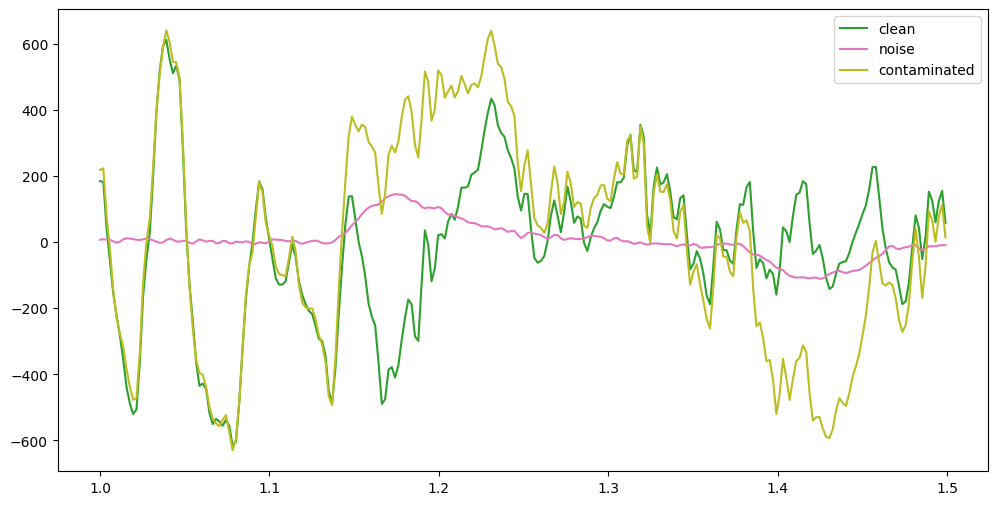

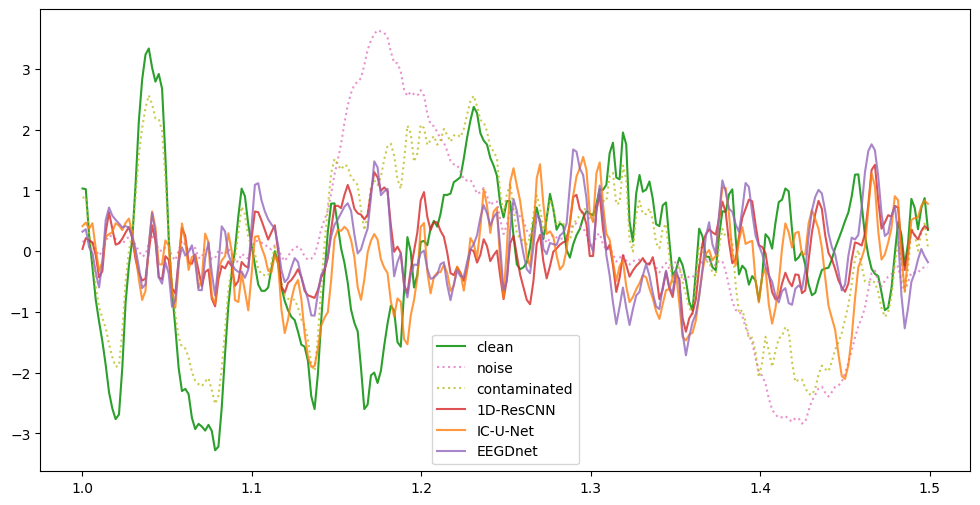

In [59]:
def from_db(x):
    return np.power(10, x/10)

def normalize(x):
    return (x - x.mean())/x.std()

snr_db = 0
snr = from_db(snr_db)
t = np.linspace(1, 2, clean_all.shape[-1])
clean_one = clean_all[0]
noisy_one = noisy_eog[0]
N = 256

clean_norm = np.linalg.norm(clean_one)
noisy_norm = np.linalg.norm(noisy_one)
lambda_ = clean_norm/noisy_norm/snr
contaminated_one = clean_one + noisy_one*lambda_

figure = plt.figure(figsize=(12, 6))
plt.plot(t[:N], clean_one[:N], label="clean", color="tab:green")
plt.plot(t[:N], noisy_one[:N], label="noise", color="tab:pink")
plt.plot(t[:N], contaminated_one[:N], label="contaminated", color="tab:olive")
plt.legend()
plt.show()

clean_one = normalize(clean_one)
noisy_one = normalize(noisy_one)
contaminated_one = normalize(contaminated_one)

ResCNN_1D_model.eval()
UNet1_model.eval()
EEGDnet_model.eval()

noisy_t = torch.tensor(noisy_one).float().to(device)[None][None]
denoised_ResCNN_1D = ResCNN_1D_model(noisy_t).cpu().detach()[0][0]
denoised_UNet1 = UNet1_model(noisy_t).cpu().detach()[0][0]
denoised_EEGDnet = EEGDnet_model(noisy_t).cpu().detach()[0][0]

figure = plt.figure(figsize=(12, 6))
plt.plot(t[:N], clean_one[:N], label="clean", color="tab:green")#, alpha=0.5, linestyle='dotted')
plt.plot(t[:N], noisy_one[:N], label="noise", color="tab:pink", alpha=0.8, linestyle='dotted')
plt.plot(t[:N], contaminated_one[:N], label="contaminated", color="tab:olive", alpha=0.8, linestyle='dotted')
plt.plot(t[:N], denoised_ResCNN_1D[:N], label="1D-ResCNN", color="tab:red", alpha=0.8)
plt.plot(t[:N], denoised_UNet1[:N], label="IC-U-Net", color="tab:orange", alpha=0.8)
plt.plot(t[:N], denoised_EEGDnet[:N], label="EEGDnet", color="tab:purple", alpha=0.8)
plt.legend()
plt.show()

## EMG

### 1D-ResCNN

In [ ]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "hidden_size": 32
}
model = ResCNN_1D(
    length=train_dataset[0][0].shape[-1],
    in_channels = 1,
    out_channels = 1,
    hidden_size = 32
).to(device)
model_description = "1D-ResCNN, hz32, 2 resblocks, ReLU"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/ResCNN_1D:v0', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/ResCNN_1D_6_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [ ]:
to_df(results)

### IC-U-Net

wandb: Downloading large artifact UNet1:v1, 533.03MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:0.6


Model is transferred to cuda
Model is in evaluation mode


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch None, step 0


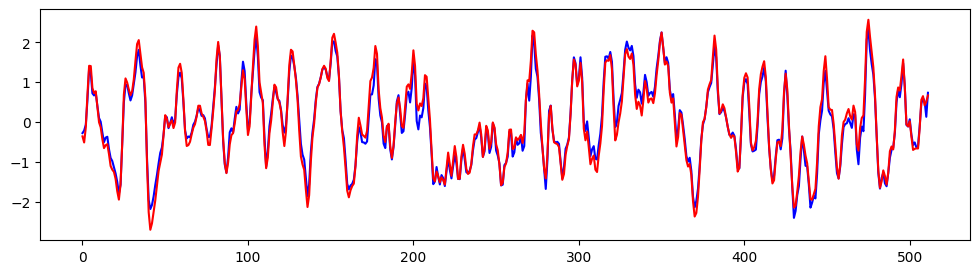

In [66]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
}
model = UNet1(
    n_channels=1,
    n_classes=1
).to(device)
model_description = "IC-U-Net, 1 ch., 64/128/256/512, 7/7/5/3/3/3/3/1, PReLU"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/UNet1:v1', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/UNet1_5_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [67]:
to_df(results)

,loss,metric,pearson_correlation,snr_db
0,17.296,0.966,0.986,14.947


### EEGDnet

In [ ]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "k": 32,
    "q": 16,
    "n_channels": 1,
    "num_heads": 1,
    "n_depths": 6,
    "mlp_ratio": 128,
    "p_dropout": 0.1
}
model = EEGDnet(
    k=model_config['k'],
    q=model_config['q'],
    n_channels=model_config['n_channels'],
    num_heads=model_config['num_heads'],
    n_depths=model_config['n_depths'],
    mlp_ratio=model_config['mlp_ratio'],
    p_dropout=model_config['p_dropout'],
    norm_layer=nn.LayerNorm,
    act_layer=nn.PReLU
).to(device)
model_description = "EEGDnet, 1 ch., k32q16h1d6mlp128, PReLU, fc end, drpt"

artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/EEGDnet:v1', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/EEGDnet_17_epoch.pth'))

model, results = train_eval(
    test_dataloader,
    model,
    mode="validation",
    plot_period=1e10,
    is_logged=False,
    device=device,
)

run.finish()

In [ ]:
to_df(results)

### Plots

In [62]:
run = wandb.init()

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "hidden_size": 32
}
ResCNN_1D_model = ResCNN_1D(
    length=train_dataset[0][0].shape[-1],
    in_channels = 1,
    out_channels = 1,
    hidden_size = 32
).to(device)
model_description = "1D-ResCNN, hz32, 2 resblocks, ReLU"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/ResCNN_1D:v0', type='model')
artifact_dir = artifact.download()
ResCNN_1D_model.load_state_dict(torch.load(artifact_dir + '/ResCNN_1D_6_epoch.pth'))

model_config = {
    "input_dim": train_dataset[0][0].shape,
}
UNet1_model = UNet1(
    n_channels=1,
    n_classes=1
).to(device)
model_description = "IC-U-Net, 1 ch., 64/128/256/512, 7/7/5/3/3/3/3/1, PReLU"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/UNet1:v1', type='model')
artifact_dir = artifact.download()
UNet1_model.load_state_dict(torch.load(artifact_dir + '/UNet1_5_epoch.pth'))

model_config = {
    "input_dim": train_dataset[0][0].shape,
    "k": 32,
    "q": 16,
    "n_channels": 1,
    "num_heads": 1,
    "n_depths": 6,
    "mlp_ratio": 128,
    "p_dropout": 0.1
}
EEGDnet_model = EEGDnet(
    k=model_config['k'],
    q=model_config['q'],
    n_channels=model_config['n_channels'],
    num_heads=model_config['num_heads'],
    n_depths=model_config['n_depths'],
    mlp_ratio=model_config['mlp_ratio'],
    p_dropout=model_config['p_dropout'],
    norm_layer=nn.LayerNorm,
    act_layer=nn.PReLU
).to(device)
model_description = "EEGDnet, 1 ch., k32q16h1d6mlp128, PReLU, fc end, drpt"
artifact = run.use_artifact('dmitriykornilov_team/EEGdenoiseNet, EMG/EEGDnet:v1', type='model')
artifact_dir = artifact.download()
EEGDnet_model.load_state_dict(torch.load(artifact_dir + '/EEGDnet_17_epoch.pth'))

run.finish()

wandb: Downloading large artifact ResCNN_1D:v0, 64.86MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:0.4
wandb: Downloading large artifact UNet1:v1, 533.03MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:7.4
wandb: Downloading large artifact EEGDnet:v1, 130.07MB. 50 files... 
wandb:   50 of 50 files downloaded.  
Done. 0:0:3.2


In [63]:
def objectName(object):
    return str(type(object)).split(".")[-1].replace("\'>", "")

n_parameters = {"model":[], "trainable":[], "total":[]}
for model in [ResCNN_1D_model, UNet1_model, EEGDnet_model]:
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_trainable = sum([np.prod(p.size()) for p in model_parameters])
    n_total = sum([np.prod(p.size()) for p in model.parameters()])
    n_parameters["model"].append(objectName(model))
    n_parameters["trainable"].append(n_trainable)
    n_parameters["total"].append(n_total)

pd.DataFrame(n_parameters)

,model,trainable,total
0,ResCNN_1D,325891,325891
1,UNet1,2777943,2777943
2,EEGDnet,675398,675398


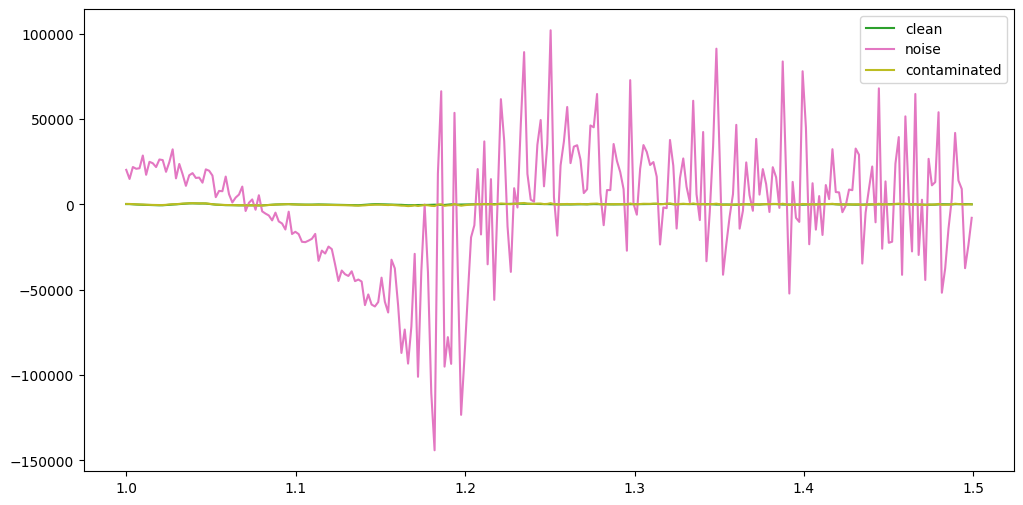

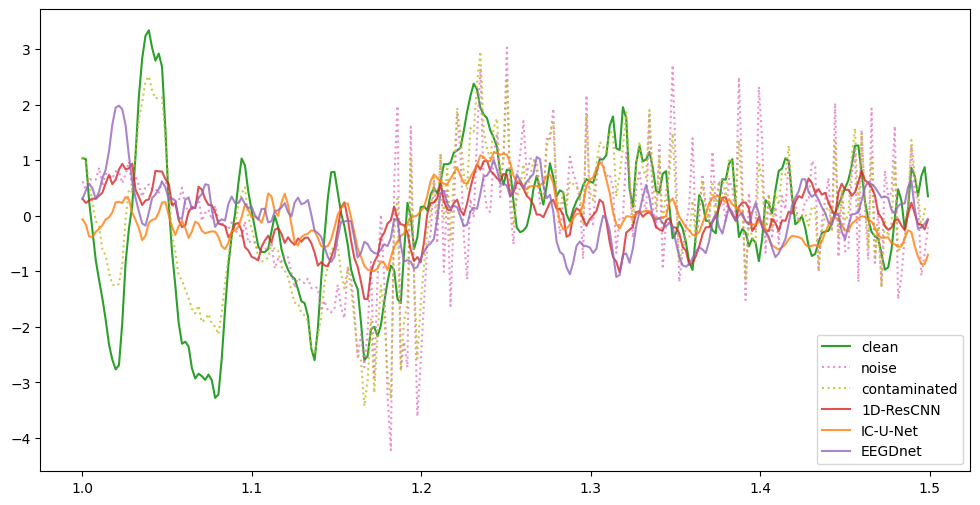

In [64]:
def from_db(x):
    return np.power(10, x/10)

def normalize(x):
    return (x - x.mean())/x.std()

snr_db = 0
snr = from_db(snr_db)
t = np.linspace(1, 2, clean_all.shape[-1])
clean_one = clean_all[0]
noisy_one = noisy_emg[0]
N = 256

clean_norm = np.linalg.norm(clean_one)
noisy_norm = np.linalg.norm(noisy_one)
lambda_ = clean_norm/noisy_norm/snr
contaminated_one = clean_one + noisy_one*lambda_

figure = plt.figure(figsize=(12, 6))
plt.plot(t[:N], clean_one[:N], label="clean", color="tab:green")
plt.plot(t[:N], noisy_one[:N], label="noise", color="tab:pink")
plt.plot(t[:N], contaminated_one[:N], label="contaminated", color="tab:olive")
plt.legend()
plt.show()

clean_one = normalize(clean_one)
noisy_one = normalize(noisy_one)
contaminated_one = normalize(contaminated_one)

ResCNN_1D_model.eval()
UNet1_model.eval()
EEGDnet_model.eval()

noisy_t = torch.tensor(noisy_one).float().to(device)[None][None]
denoised_ResCNN_1D = ResCNN_1D_model(noisy_t).cpu().detach()[0][0]
denoised_UNet1 = UNet1_model(noisy_t).cpu().detach()[0][0]
denoised_EEGDnet = EEGDnet_model(noisy_t).cpu().detach()[0][0]

figure = plt.figure(figsize=(12, 6))
plt.plot(t[:N], clean_one[:N], label="clean", color="tab:green")#, alpha=0.5, linestyle='dotted')
plt.plot(t[:N], noisy_one[:N], label="noise", color="tab:pink", alpha=0.8, linestyle='dotted')
plt.plot(t[:N], contaminated_one[:N], label="contaminated", color="tab:olive", alpha=0.8, linestyle='dotted')
plt.plot(t[:N], denoised_ResCNN_1D[:N], label="1D-ResCNN", color="tab:red", alpha=0.8)
plt.plot(t[:N], denoised_UNet1[:N], label="IC-U-Net", color="tab:orange", alpha=0.8)
plt.plot(t[:N], denoised_EEGDnet[:N], label="EEGDnet", color="tab:purple", alpha=0.8)
plt.legend()
plt.show()